<a href="https://colab.research.google.com/github/ad-batrisyia/money-laundering-detection-ml/blob/main/notebooks/02_Feature_Transformation_Engineering_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path
file_path = '/content/drive/My Drive/Money Laundering Detection/SAML-D.csv'

# Load the dataset
import pandas as pd
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


## FEATURE TRANSFORMATION

In [ ]:
# --- Convert Date and Time properly ---
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + " " + df['Time'].astype(str))

# -------------------
# 1. Temporal Features
# -------------------
# Time of Day (day: 6AM-6PM, night: 6PM-6AM)
df['TimeOfDay'] = df['DateTime'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

# Weekend Flag
df['Is_Weekend'] = df['DateTime'].dt.weekday >= 5

# Transaction Frequency (per sender per day)
df['Tx_per_Day'] = df.groupby(['Sender_account', df['DateTime'].dt.date])['Amount'].transform('count')

# Average Transaction Interval (seconds) per sender
df['Tx_Interval'] = df.groupby('Sender_account')['DateTime'].diff().dt.total_seconds()

#Descriptive Stats for Tx_Interval
df['Tx_Interval'].describe().apply(lambda x: f"{x:.2f}")

,Tx_Interval
count,9212137.00
mean,190696.32
std,841797.00
min,0.00
25%,842.00
50%,10707.00
75%,88934.00
max,27394491.00


In [ ]:
# -------------------
# 2. Transaction-Related Features
# -------------------
# Average transaction amount per sender
df['Avg_Amount_Sent'] = df.groupby('Sender_account')['Amount'].transform('mean')

In [ ]:
# Pair bank + currency
df['Pair_bank_location'] = df['Sender_bank_location'] + "-" + df['Receiver_bank_location']
df['Pair_currency'] = df['Payment_currency'] + "-" + df['Received_currency']

In [ ]:
# Define the mapping dictionary
laundering_structure_map = {
    'Normal_Cash_Deposits': 'Cash_Deposit',
    'Normal_Fan_Out': 'Fan-Out',
    'Normal_Small_Fan_Out': 'Fan-Out',
    'Layered_Fan_Out': 'Fan-Out',
    'Fan_Out': 'Fan-Out',
    'Normal_Fan_In': 'Fan-In',
    'Layered_Fan_In': 'Fan-In',
    'Fan_In': 'Fan-In',
    'Normal_Cash_Withdrawal': 'Cash_Withdrawal',
    'Cash_Withdrawal': 'Cash_Withdrawal',
    'Normal_Group': 'Behavioral_Group',
    'Behavioural_Change_1': 'Behavioral_Group',
    'Behavioural_Change_2': 'Behavioral_Group',
    'Normal_Mutual': 'Mutual',
    'Normal_Plus_Mutual': 'Mutual',
    'Normal_Foward': 'Forward',
    'Deposit-Send': 'Forward',
    'Normal_Periodical': 'Periodical',
    'Smurfing': 'Structuring',
    'Structuring': 'Structuring',
    'Cycle': 'Cycle',
    'Stacked Bipartite': 'Bipartite',
    'Bipartite': 'Bipartite',
    'Scatter-Gather': 'Scatter-Gather',
    'Gather-Scatter': 'Gather-Scatter',
    'Normal_single_large': 'Single_Large',
    'Single_large': 'Single_Large',
    'Over-Invoicing': 'Over-Invoicing'
}

# Map the values to a new column
df['Laundering_Structure'] = df['Laundering_type'].map(laundering_structure_map)

# Optional: Check result
print(df[['Laundering_type', 'Laundering_Structure']].drop_duplicates().sort_values('Laundering_Structure'))

               Laundering_type Laundering_Structure
1649      Behavioural_Change_2     Behavioral_Group
3481      Behavioural_Change_1     Behavioral_Group
5                 Normal_Group     Behavioral_Group
163560               Bipartite            Bipartite
16342        Stacked Bipartite            Bipartite
0         Normal_Cash_Deposits         Cash_Deposit
1206           Cash_Withdrawal      Cash_Withdrawal
55      Normal_Cash_Withdrawal      Cash_Withdrawal
11831                    Cycle                Cycle
3983            Layered_Fan_In               Fan-In
14765                   Fan_In               Fan-In
3                Normal_Fan_In               Fan-In
1               Normal_Fan_Out              Fan-Out
2         Normal_Small_Fan_Out              Fan-Out
4664           Layered_Fan_Out              Fan-Out
227254                 Fan_Out              Fan-Out
51415             Deposit-Send              Forward
82               Normal_Foward              Forward
177615      

In [ ]:
print(df['Laundering_Structure'].unique())

['Cash_Deposit' 'Fan-Out' 'Fan-In' 'Behavioral_Group' 'Cash_Withdrawal'
 'Periodical' 'Forward' 'Mutual' 'Structuring' 'Single_Large'
 'Scatter-Gather' 'Cycle' 'Bipartite' 'Over-Invoicing' 'Gather-Scatter']


In [ ]:
df.dtypes

,0
Time,object
Date,datetime64[ns]
Sender_account,int64
Receiver_account,int64
Amount,float64
Payment_currency,object
Received_currency,object
Sender_bank_location,object
Receiver_bank_location,object
Payment_type,object


In [ ]:
# Function to check memory usage per column
def memory_usage(df):
    mem = df.memory_usage(deep=True) / 1024**2  # in MB
    return mem.sort_values(ascending=False)

# --- Before conversion ---
print("=== BEFORE Conversion ===")
print(memory_usage(df).head(15))   # top 15 biggest columns
print(f"Total Memory: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

# --- Convert types ---
for col in ['Sender_account', 'Receiver_account','Payment_currency',
            'Received_currency','Sender_bank_location', 'Receiver_bank_location',
            'Payment_type', 'Laundering_type','TimeOfDay',
            'Pair_bank_location','Pair_currency', 'Laundering_Structure']:
    df[col] = df[col].astype('category')

for col in ['Is_Weekend', 'Is_laundering']:
    df[col] = df[col].astype('int8')

# --- After conversion ---
print("\n=== AFTER Conversion ===")
print(memory_usage(df).head(15))
print(f"Total Memory: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")


=== BEFORE Conversion ===
Pair_currency             615.599570
Laundering_type           592.676091
Payment_currency          525.502436
Received_currency         525.194730
Payment_type              519.287597
Laundering_Structure      514.003032
Pair_bank_location        493.535144
TimeOfDay                 478.688660
Receiver_bank_location    464.991275
Sender_bank_location      463.641464
Time                      435.097595
Date                       72.516266
Sender_account             72.516266
Receiver_account           72.516266
Tx_per_Day                 72.516266
dtype: float64
Total Memory: 6289.93 MB

=== AFTER Conversion ===
Time                      435.097595
Date                       72.516266
Amount                     72.516266
Tx_per_Day                 72.516266
Avg_Amount_Sent            72.516266
DateTime                   72.516266
Tx_Interval                72.516266
Receiver_account           57.359566
Sender_account             46.553909
Pair_bank_location  

### Data Cleaning

In [ ]:
#Check for missing values
print(df.isnull().sum())

Time                           0
Date                           0
Sender_account                 0
Receiver_account               0
Amount                         0
Payment_currency               0
Received_currency              0
Sender_bank_location           0
Receiver_bank_location         0
Payment_type                   0
Is_laundering                  0
Laundering_type                0
DateTime                       0
TimeOfDay                      0
Is_Weekend                     0
Tx_per_Day                     0
Tx_Interval               292715
Avg_Amount_Sent                0
Pair_bank_location             0
Pair_currency                  0
Laundering_Structure           0
dtype: int64


In [ ]:
df['Tx_Interval'] = df['Tx_Interval'].fillna(0)

In [ ]:
print(df.isnull().sum())

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
DateTime                  0
TimeOfDay                 0
Is_Weekend                0
Tx_per_Day                0
Tx_Interval               0
Avg_Amount_Sent           0
Pair_bank_location        0
Pair_currency             0
Laundering_Structure      0
dtype: int64


In [ ]:
#Check for duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,...,Laundering_type,DateTime,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Pair_currency,Laundering_Structure
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,...,Normal_Cash_Deposits,2022-10-07 10:35:19,Day,0,1,0.0,1857.866667,UK-UK,UK pounds-UK pounds,Cash_Deposit
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,...,Normal_Fan_Out,2022-10-07 10:35:20,Day,0,102,0.0,5889.320323,UK-UAE,UK pounds-Dirham,Fan-Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,...,Normal_Small_Fan_Out,2022-10-07 10:35:20,Day,0,3,0.0,10167.677647,UK-UK,UK pounds-UK pounds,Fan-Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,...,Normal_Fan_In,2022-10-07 10:35:21,Day,0,9,0.0,11937.773333,UK-UK,UK pounds-UK pounds,Fan-In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,...,Normal_Cash_Deposits,2022-10-07 10:35:21,Day,0,1,0.0,1068.905000,UK-UK,UK pounds-UK pounds,Cash_Deposit


In [ ]:
output_path = '/content/drive/MyDrive/Money Laundering Detection/PreprocessedDataforDashboard.csv'
df.to_csv(output_path, index=False)

print(f"File saved to: {output_path}")

File saved to: /content/drive/MyDrive/Money Laundering Detection/PreprocessedDataforDashboard.csv


In [ ]:
#Drop the irrelevant columns
df = df.drop(columns=['Sender_account', 'Receiver_account', 'Date', 'Time', 'DateTime',
                      'Payment_currency', 'Received_currency',
                      'Sender_bank_location', 'Receiver_bank_location', 'Laundering_type'])

In [ ]:
df.dtypes

,0
Amount,float64
Payment_type,category
Is_laundering,int8
TimeOfDay,category
Is_Weekend,int8
Tx_per_Day,int64
Tx_Interval,float64
Avg_Amount_Sent,float64
Pair_bank_location,category
Pair_currency,category


In [ ]:
df.head()

,Amount,Payment_type,Is_laundering,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Pair_currency,Laundering_Structure
0,1459.15,Cash Deposit,0,Day,0,1,0.0,1857.866667,UK-UK,UK pounds-UK pounds,Cash_Deposit
1,6019.64,Cross-border,0,Day,0,102,0.0,5889.320323,UK-UAE,UK pounds-Dirham,Fan-Out
2,14328.44,Cheque,0,Day,0,3,0.0,10167.677647,UK-UK,UK pounds-UK pounds,Fan-Out
3,11895.00,ACH,0,Day,0,9,0.0,11937.773333,UK-UK,UK pounds-UK pounds,Fan-In
4,115.25,Cash Deposit,0,Day,0,1,0.0,1068.905000,UK-UK,UK pounds-UK pounds,Cash_Deposit


## FEATURE ENGINEERING

### Label Encoding

In [ ]:
df.dtypes

,0
Amount,float64
Payment_type,category
Is_laundering,int8
TimeOfDay,category
Is_Weekend,int8
Tx_per_Day,int64
Tx_Interval,float64
Avg_Amount_Sent,float64
Pair_bank_location,category
Pair_currency,category


In [ ]:
#Encode Categorical Columns

#Check Categorical columns
categorical_cols = df.select_dtypes(include='category').columns

categorical_cols

Index(['Payment_type', 'TimeOfDay', 'Pair_bank_location', 'Pair_currency',
       'Laundering_Structure'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Label encod each one
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,Amount,Payment_type,Is_laundering,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Pair_currency,Laundering_Structure
0,1459.15,1,0,0,0,1,0.0,1857.866667,304,140,2
1,6019.64,5,0,0,0,102,0.0,5889.320323,303,131,6
2,14328.44,3,0,0,0,3,0.0,10167.677647,304,140,6
3,11895.00,0,0,0,0,9,0.0,11937.773333,304,140,5
4,115.25,1,0,0,0,1,0.0,1068.905000,304,140,2


## FEATURE SELECTION

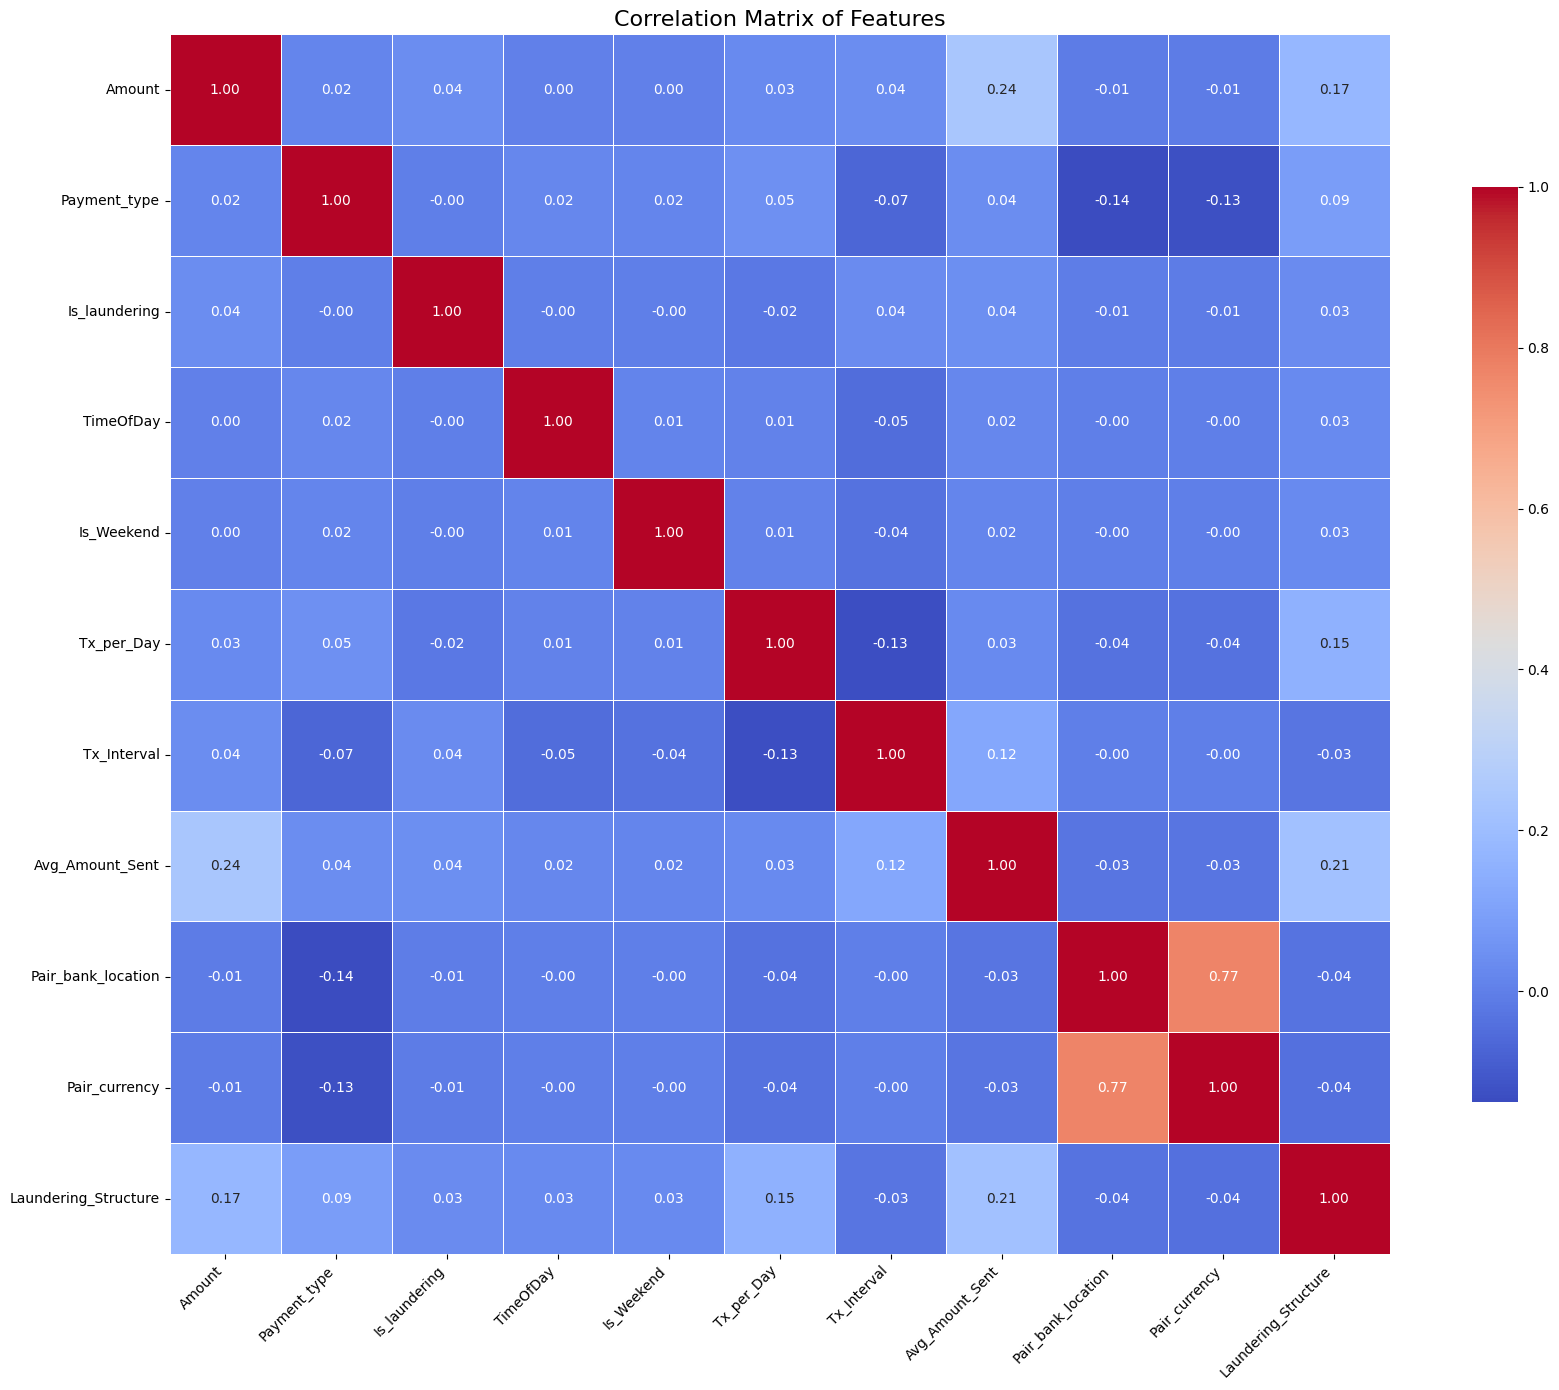

In [ ]:
# Compute the correlation matrix
correlation_matrix = df.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': .75})
plt.title("Correlation Matrix of Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Get correlation of each feature with the target
target_corr = correlation_matrix['Is_laundering'].sort_values(key=abs, ascending=False)

print("Correlation with target (Is_laundering):")
print(target_corr)

Correlation with target (Is_laundering):
Is_laundering           1.000000
Avg_Amount_Sent         0.043097
Amount                  0.040063
Tx_Interval             0.036000
Laundering_Structure    0.032118
Tx_per_Day             -0.018762
Pair_currency          -0.010520
Pair_bank_location     -0.006455
Payment_type           -0.001736
TimeOfDay              -0.001534
Is_Weekend             -0.001140
Name: Is_laundering, dtype: float64


In [ ]:
# Find pairs with high correlation
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]  # remove self-correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.70]  # threshold
print(high_corr_pairs)

Pair_currency       Pair_bank_location    0.770277
Pair_bank_location  Pair_currency         0.770277
dtype: float64


In [ ]:
df_final = df.drop(columns=['Pair_currency'])

In [ ]:
df_final

,Amount,Payment_type,Is_laundering,TimeOfDay,Is_Weekend,Tx_per_Day,Tx_Interval,Avg_Amount_Sent,Pair_bank_location,Laundering_Structure
0,1459.15,1,0,0,0,1,0.0,1857.866667,304,2
1,6019.64,5,0,0,0,102,0.0,5889.320323,303,6
2,14328.44,3,0,0,0,3,0.0,10167.677647,304,6
3,11895.00,0,0,0,0,9,0.0,11937.773333,304,5
4,115.25,1,0,0,0,1,0.0,1068.905000,304,2
...,...,...,...,...,...,...,...,...,...,...
9504847,2247.25,0,0,0,0,2,11927.0,7585.677097,304,6
9504848,927.18,6,0,0,0,1,143171.0,9468.448370,304,6
9504849,1455.14,0,0,0,0,1,52168.0,7932.502613,304,6
9504850,25995.70,0,0,0,0,3,7832.0,26028.330000,304,5


In [ ]:
output_path = '/content/drive/MyDrive/Money Laundering Detection/PreprocessedData.csv'
df_final.to_csv(output_path, index=False)

print(f"File saved to: {output_path}")

File saved to: /content/drive/MyDrive/Money Laundering Detection/PreprocessedData.csv
